# Predicting Hospital Readmission for Diabetic Patients

##  Problem Statement

Hospital readmission occurs when a patient, after being discharged, is admitted again within a specific period. High readmission rates negatively impact hospital quality scores and increase healthcare costs. The **Centers for Medicare & Medicaid Services (CMS)** introduced the **Hospital Readmissions Reduction Program (HRRP)** to penalize hospitals with excessive readmissions.

Although diabetes is not currently included in HRRP penalties, it remains a costly chronic disease, with **over $41 billion spent in 2011** on readmissions within 30 days of discharge. Accurately predicting which diabetic patients are at higher risk of early readmission can help hospitals **reduce costs, allocate resources efficiently, and improve patient care**.

##  Objective

This study aims to develop a predictive model that determines the **likelihood of diabetic patients being readmitted within 30 days** of discharge. By analyzing patient demographics, clinical procedures, and hospital attributes, we seek to:

- **Identify key factors** influencing hospital readmissions for diabetic patients.
- **Develop machine learning models** to predict readmission risk.
- **Provide insights** to hospitals for optimizing diabetes management and reducing costs.




#### Libraries

In [70]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from tensorflow.keras.metrics import Precision, Recall

from sklearn.linear_model import LogisticRegression



### Creating functions

In [30]:
# Creating a function that converts the ICD-9 codes into broad disease categories

def categorize_icd9(code):
    """ Convert ICD-9 codes into broad disease categories """
    if pd.isna(code):
        return "Unknown"
    code = str(code)
    
    if code.startswith('V'):
        return "V-Code (Health Services)"
    if code.startswith('E'):
        return "E-Code (External Injury)"

    try:
        code = int(float(code))
        if 1 <= code <= 139:
            return "Infectious Disease"
        elif 140 <= code <= 239:
            return "Neoplasms"
        elif 240 <= code <= 279:
            return "Endocrine (e.g., Diabetes)"
        elif 280 <= code <= 289:
            return "Blood Diseases"
        elif 290 <= code <= 319:
            return "Mental Disorders"
        elif 320 <= code <= 389:
            return "Nervous System"
        elif 390 <= code <= 459:
            return "Circulatory System"
        elif 460 <= code <= 519:
            return "Respiratory System"
        elif 520 <= code <= 579:
            return "Digestive System"
        elif 580 <= code <= 629:
            return "Genitourinary System"
        elif 630 <= code <= 679:
            return "Pregnancy-related"
        elif 680 <= code <= 709:
            return "Skin Diseases"
        elif 710 <= code <= 739:
            return "Musculoskeletal"
        elif 740 <= code <= 759:
            return "Congenital Disorders"
        elif 760 <= code <= 779:
            return "Perinatal Conditions"
        elif 780 <= code <= 799:
            return "Symptoms & Ill-defined"
        elif 800 <= code <= 999:
            return "Injury & Poisoning"
    except ValueError:
        return "Unknown"
    
    return "Other"


### Importing data

In [31]:
# importin data
data= pd.read_csv('diabetic_data.csv')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [33]:
# Cheking what rows need encoding

numerical_columns = list(data.select_dtypes(include=['number']).columns)
categorical_columns = data.select_dtypes(include='object').columns

print("Numerical Columns:")
print("\n".join(f"- {col}" for col in numerical_columns))
print("\nCategorical Columns:")
print("\n".join(f"- {col}" for col in categorical_columns))

Numerical Columns:
- encounter_id
- patient_nbr
- admission_type_id
- discharge_disposition_id
- admission_source_id
- time_in_hospital
- num_lab_procedures
- num_procedures
- num_medications
- number_outpatient
- number_emergency
- number_inpatient
- number_diagnoses

Categorical Columns:
- race
- gender
- age
- weight
- payer_code
- medical_specialty
- diag_1
- diag_2
- diag_3
- max_glu_serum
- A1Cresult
- metformin
- repaglinide
- nateglinide
- chlorpropamide
- glimepiride
- acetohexamide
- glipizide
- glyburide
- tolbutamide
- pioglitazone
- rosiglitazone
- acarbose
- miglitol
- troglitazone
- tolazamide
- examide
- citoglipton
- insulin
- glyburide-metformin
- glipizide-metformin
- glimepiride-pioglitazone
- metformin-rosiglitazone
- metformin-pioglitazone
- change
- diabetesMed
- readmitted


In [34]:
data.sample(5).T

,15739,63333,17842,18331,37825
encounter_id,60030018,176151366,65167212,66472542,117389916
patient_nbr,24054849,108545877,19759194,23933205,23263623
race,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican
gender,Female,Female,Female,Female,Female
age,[30-40),[90-100),[0-10),[50-60),[40-50)
weight,?,?,?,?,?
admission_type_id,5,2,1,2,1
discharge_disposition_id,1,1,1,1,1
admission_source_id,17,7,1,17,7
time_in_hospital,2,2,3,11,4


### Checking missing values

In [35]:
print('gender', data['gender'][data['gender'] == 'Unknown/Invalid'].count())

#missing values in dataset are represented by '?' so we replace them with NaN
data.replace('?', np.nan, inplace=True)

# changing unknown/invalid no NaN
data = data[data['gender'] != 'Unknown/Invalid']

gender 3


In [36]:
# Checking and summarizing missing values
missing_data = data.isnull().sum().loc[lambda x: x > 0].sort_values(ascending=False)
missing_summary = pd.DataFrame({
    "Missing Count": missing_data,
    "Missing Percentage (%)": (missing_data / len(data) * 100).round(2)
})

# Display styled missing values summary
display(
    missing_summary.style
    .format({"Missing Percentage (%)": "{:.2f}%"})
    .set_caption("**Missing Values Summary**")
    .set_properties(**{"text-align": "center"})
)

,Missing Count,Missing Percentage (%)
weight,98566,96.86%
max_glu_serum,96417,94.75%
A1Cresult,84745,83.28%
medical_specialty,49947,49.08%
payer_code,40255,39.56%
race,2271,2.23%
diag_3,1423,1.40%
diag_2,358,0.35%
diag_1,21,0.02%


#### Handling Missing Values
we identified missing values in several columns, including `max_glu_serum` (94.7% missing), `A1Cresult` (83.3% missing), and others such as `weight`, `medical_specialty`, and `payer_code`. 
#### Decision on Missing Data

- **Dropped Columns:**  
  We removed `weight`, `medical_specialty`, and `payer_code` because they contain excessive missing values (≥ 39%), making them unreliable for analysis.

- **Retained Columns:**  
  We kept `max_glu_serum` and `A1Cresult`, despite their high missing rates, as they provide **meaningful information** rather than random gaps.  
  - In this case, `"None"` is not a true missing value (`NaN`), but an indicator that the test was **not performed** for a given patient.

- **Row Removal:**  
  Columns like `diag_1`, `diag_2`, `diag_3`, and `race` had **insignificant missing values** (≤ 2.2%). Therefore, we removed the rows containing missing values in these columns.


In [37]:
# drop columns with more than 39% missing values
data= data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

# drop rows with missing values
data= data.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'])

# Fill NaN values with 0 using explicit assignment to avoid FutureWarning
data = data.copy()
data['max_glu_serum'] = data['max_glu_serum'].fillna(0)
data['A1Cresult'] = data['A1Cresult'].fillna(0)

# Verify the changes
print(data['max_glu_serum'].value_counts(dropna=False))
print(data['A1Cresult'].value_counts(dropna=False))




max_glu_serum
0       92844
Norm     2532
>200     1449
>300     1227
Name: count, dtype: int64
A1Cresult
0       81859
>8       7631
Norm     4854
>7       3708
Name: count, dtype: int64


In [38]:
# Checking if all missing values where delt with
missing_values = data.isnull().sum()

if missing_values.any():
        print(missing_values[missing_values>0])
else:
    print('-'*20)
    print('No missing values')
    print('-'*20)

--------------------
No missing values
--------------------


## Analise data

Target Variable, **`readmitted`**, includes three possible values:  
- **>30** (Patient readmitted after more than 30 days)  
- **<30** (Patient readmitted within 30 days)  
- **NO** (Patient was not readmitted)   

Since our primary focus is determining **whether a patient was readmitted or not**, rather than the specific time frame of readmission, we consolidate the categories as follows:  

- **Positive Outcome (Readmitted):** Both **>30** and **<30** are mapped to `1`.  
- **Negative Outcome (Not Readmitted):** **NO** is mapped to `0`.  



In [39]:
# Convert the target variable to binary

data['readmitted_binary'] = data['readmitted'].map({'NO': 0, '>30': 1, '<30': 1})

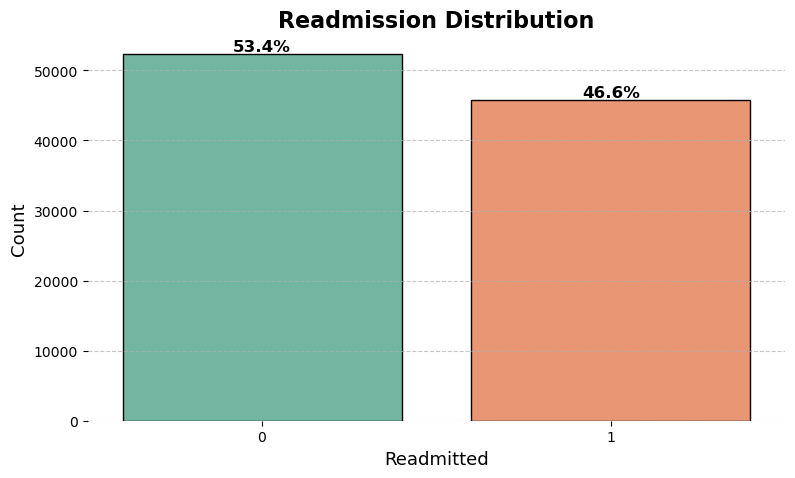

In [40]:
# Plot count distribution
plt.figure(figsize=(9, 5))
ax = sns.countplot(x='readmitted_binary', hue='readmitted_binary', data=data, 
                   palette='Set2', edgecolor='black', legend=False)

# Annotate bars with percentage labels
total = len(data)
for p in ax.patches:
    ax.annotate(f"{p.get_height() / total:.1%}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
plt.title('Readmission Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Readmitted', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

plt.show()

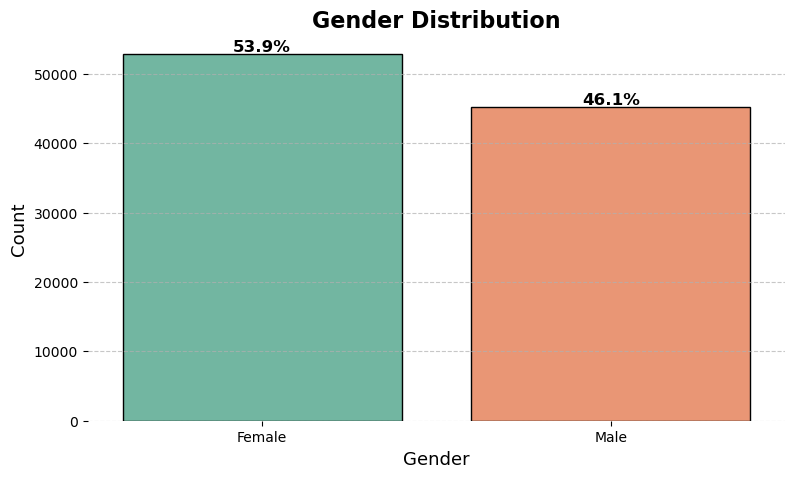

In [41]:
# Plot gender distribution
plt.figure(figsize=(9, 5))
ax = sns.countplot(x='gender', hue='gender', data=data, palette='Set2', edgecolor='black', legend=False)

# Annotate bars with percentages
total = len(data)
for p in ax.patches:
    ax.annotate(f"{p.get_height() / total:.1%}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
plt.title('Gender Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

plt.show()


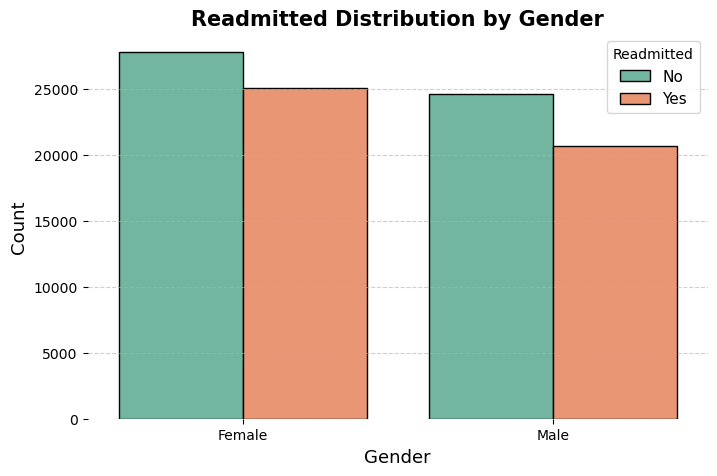

In [42]:
# Figure setup
plt.figure(figsize=(8, 5))

# Count plot with better color and auto-handled categorical labels
ax = sns.countplot(
    x='gender', hue='readmitted_binary', data=data, palette='Set2', edgecolor='black'
)

# Labels & Title
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Readmitted Distribution by Gender', fontsize=15, fontweight='bold')

# Improved legend with proper labels
plt.legend(title="Readmitted", labels=["No", "Yes"], fontsize=11)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, bottom=True)

plt.show()


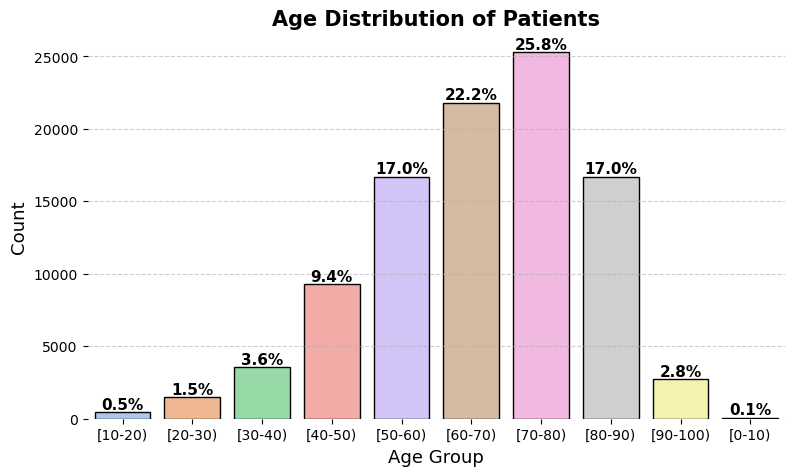

In [43]:
# Plot age distribution
plt.figure(figsize=(9, 5))
ax = sns.countplot(x="age",hue='age', data=data, palette="pastel", edgecolor="black")

# Add percentage labels
total = len(data)
for p in ax.patches:
    ax.annotate(f"{p.get_height() / total:.1%}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Formatting
plt.xlabel('Age Group', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Age Distribution of Patients', fontsize=15, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, bottom=True)

plt.show()

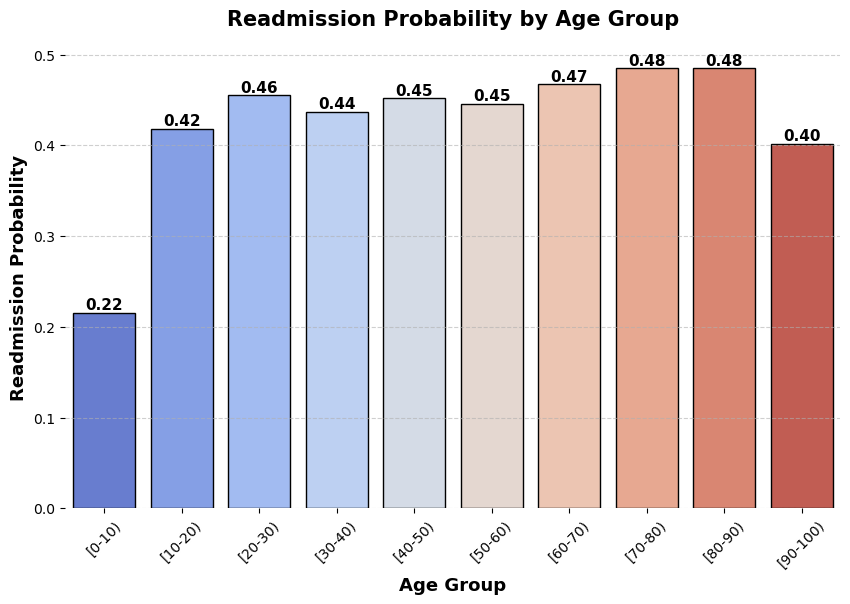

In [44]:
# Compute readmission probability per age group
age_readmit_rates = data.groupby('age')['readmitted_binary'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="age", y="readmitted_binary", hue="age", data=age_readmit_rates, 
                 palette="coolwarm", edgecolor="black", legend=False)

# Add data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Formatting
plt.xlabel("Age Group", fontsize=13, fontweight='bold')
plt.ylabel("Readmission Probability", fontsize=13, fontweight='bold')
plt.title("Readmission Probability by Age Group", fontsize=15, fontweight='bold', pad=15)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, bottom=True)

plt.show()

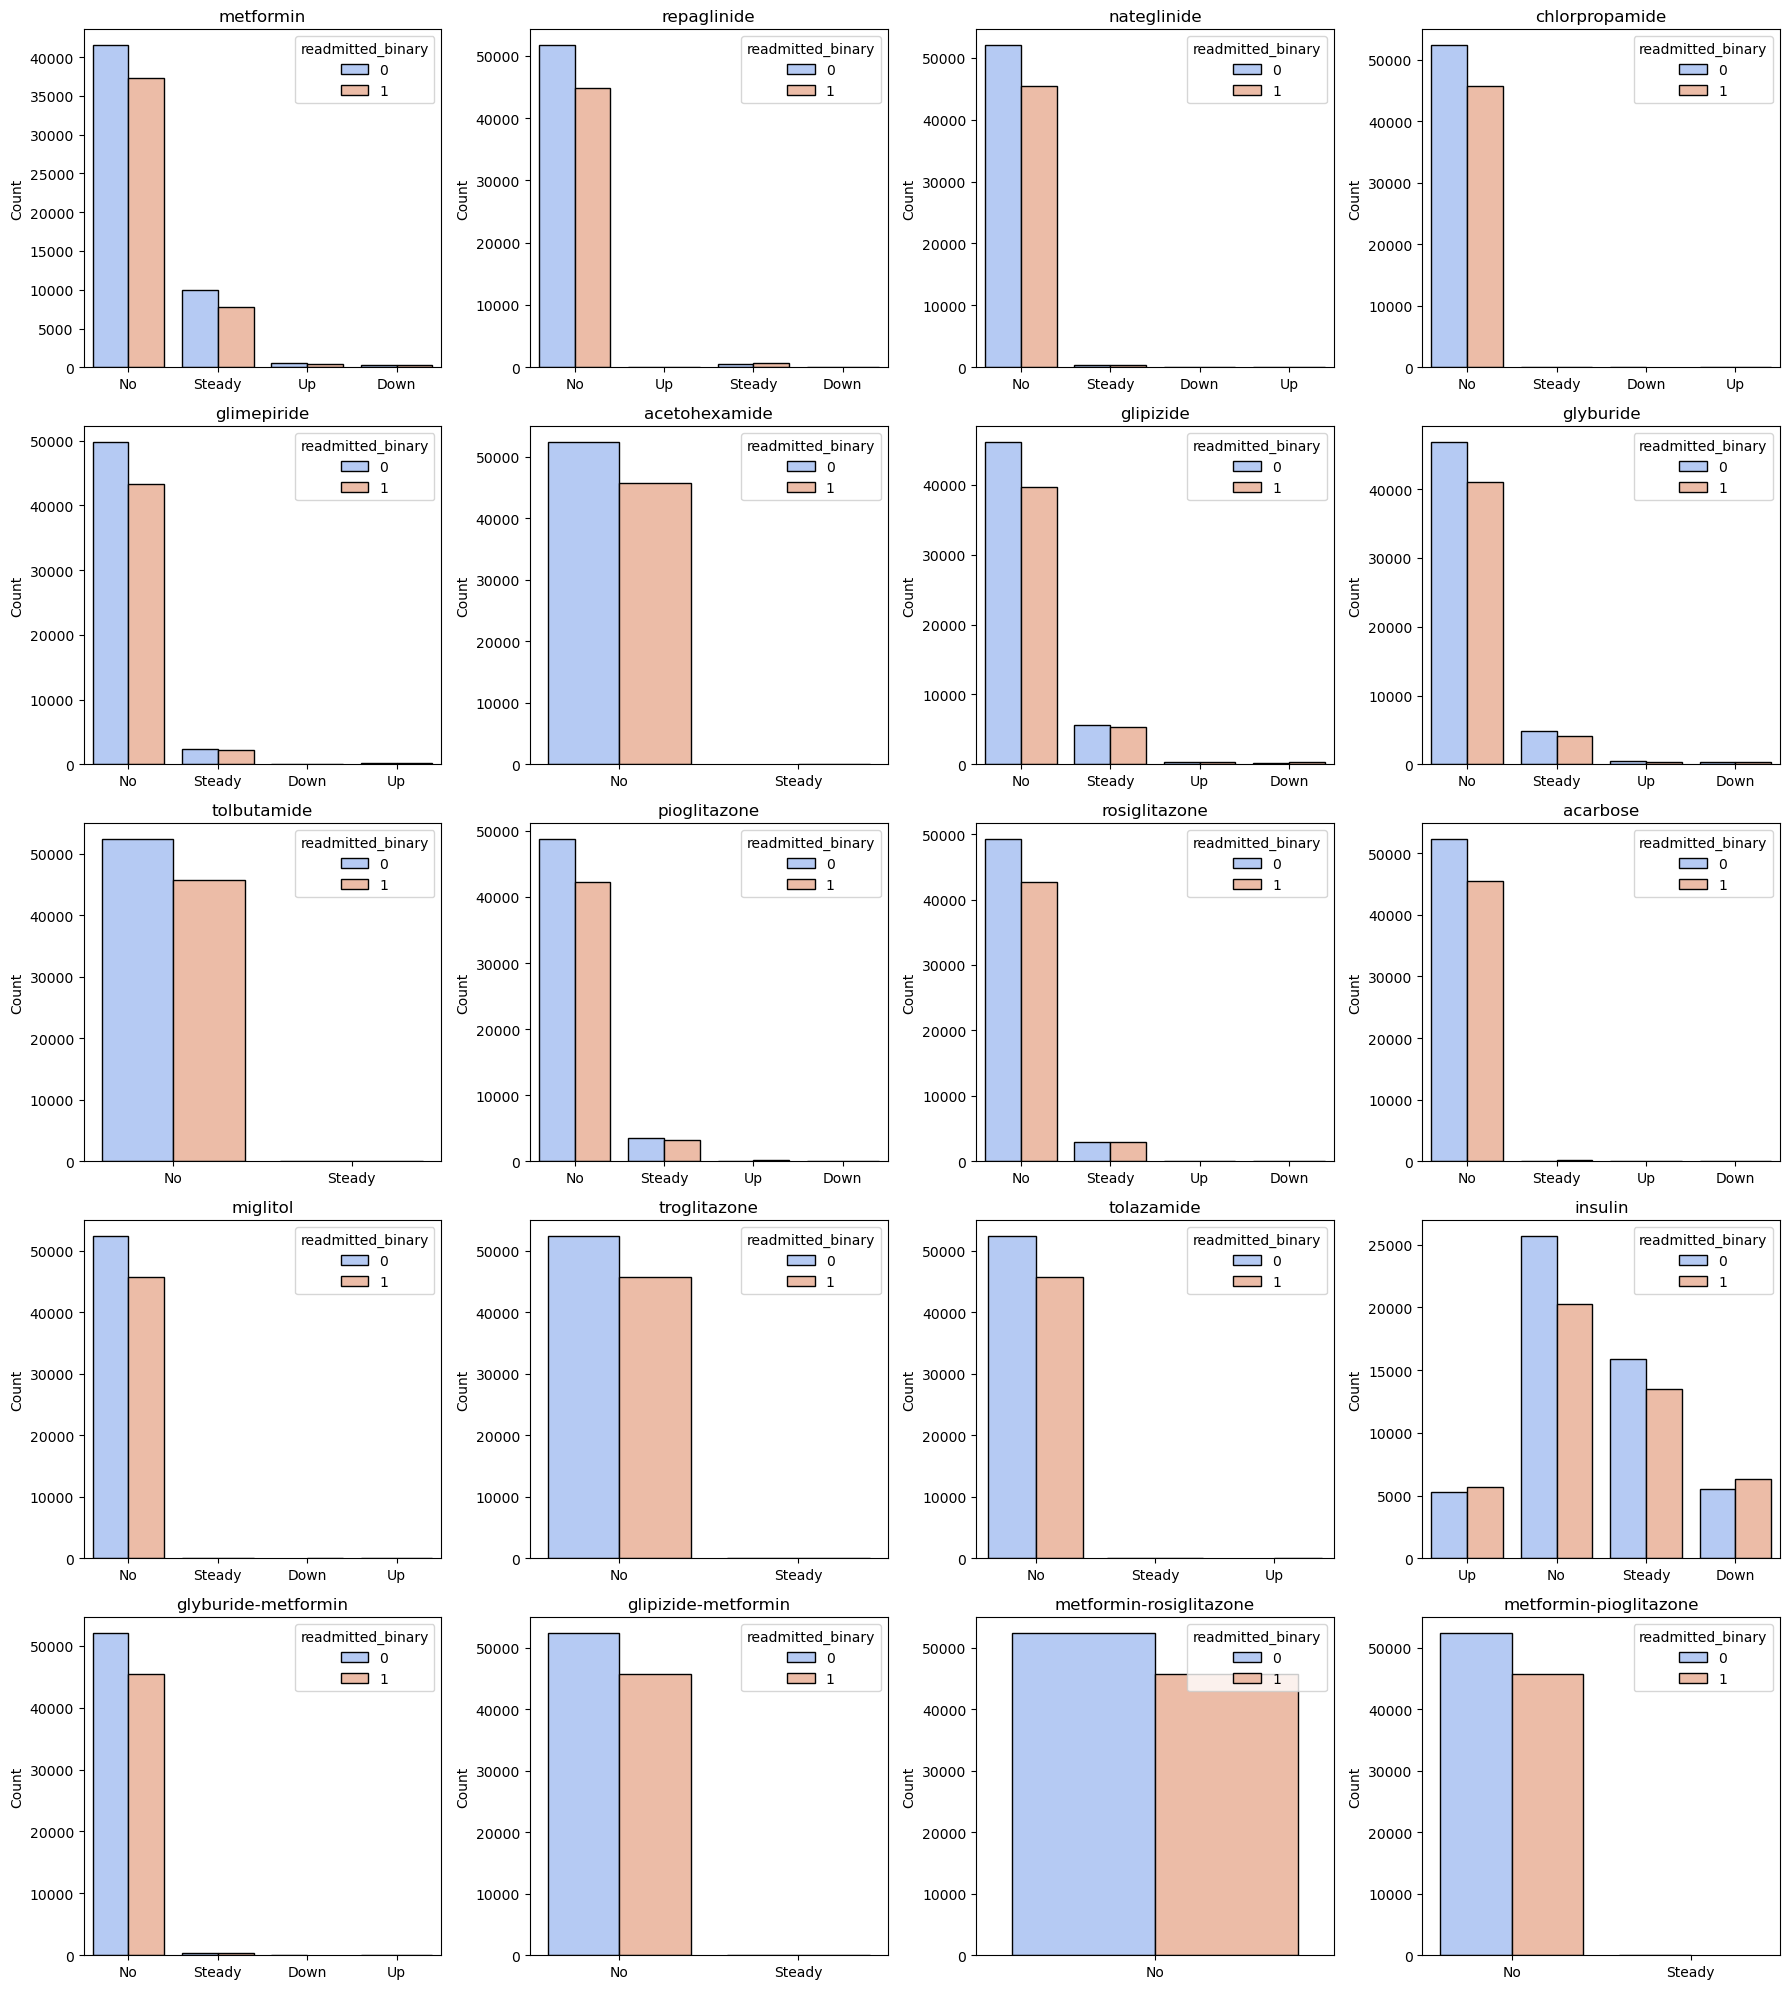

In [45]:
# List of drug columns
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
             'metformin-rosiglitazone', 'metformin-pioglitazone']

# Create subplots with multiple drug distributions
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 20))
axes = axes.flatten()

# Loop through each drug and plot on its respective subplot
for idx, drug in enumerate(drug_cols):
    sns.countplot(x=drug, hue="readmitted_binary", data=data, palette="coolwarm", edgecolor="black", ax=axes[idx])
    axes[idx].set_title(drug, fontsize=12)
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

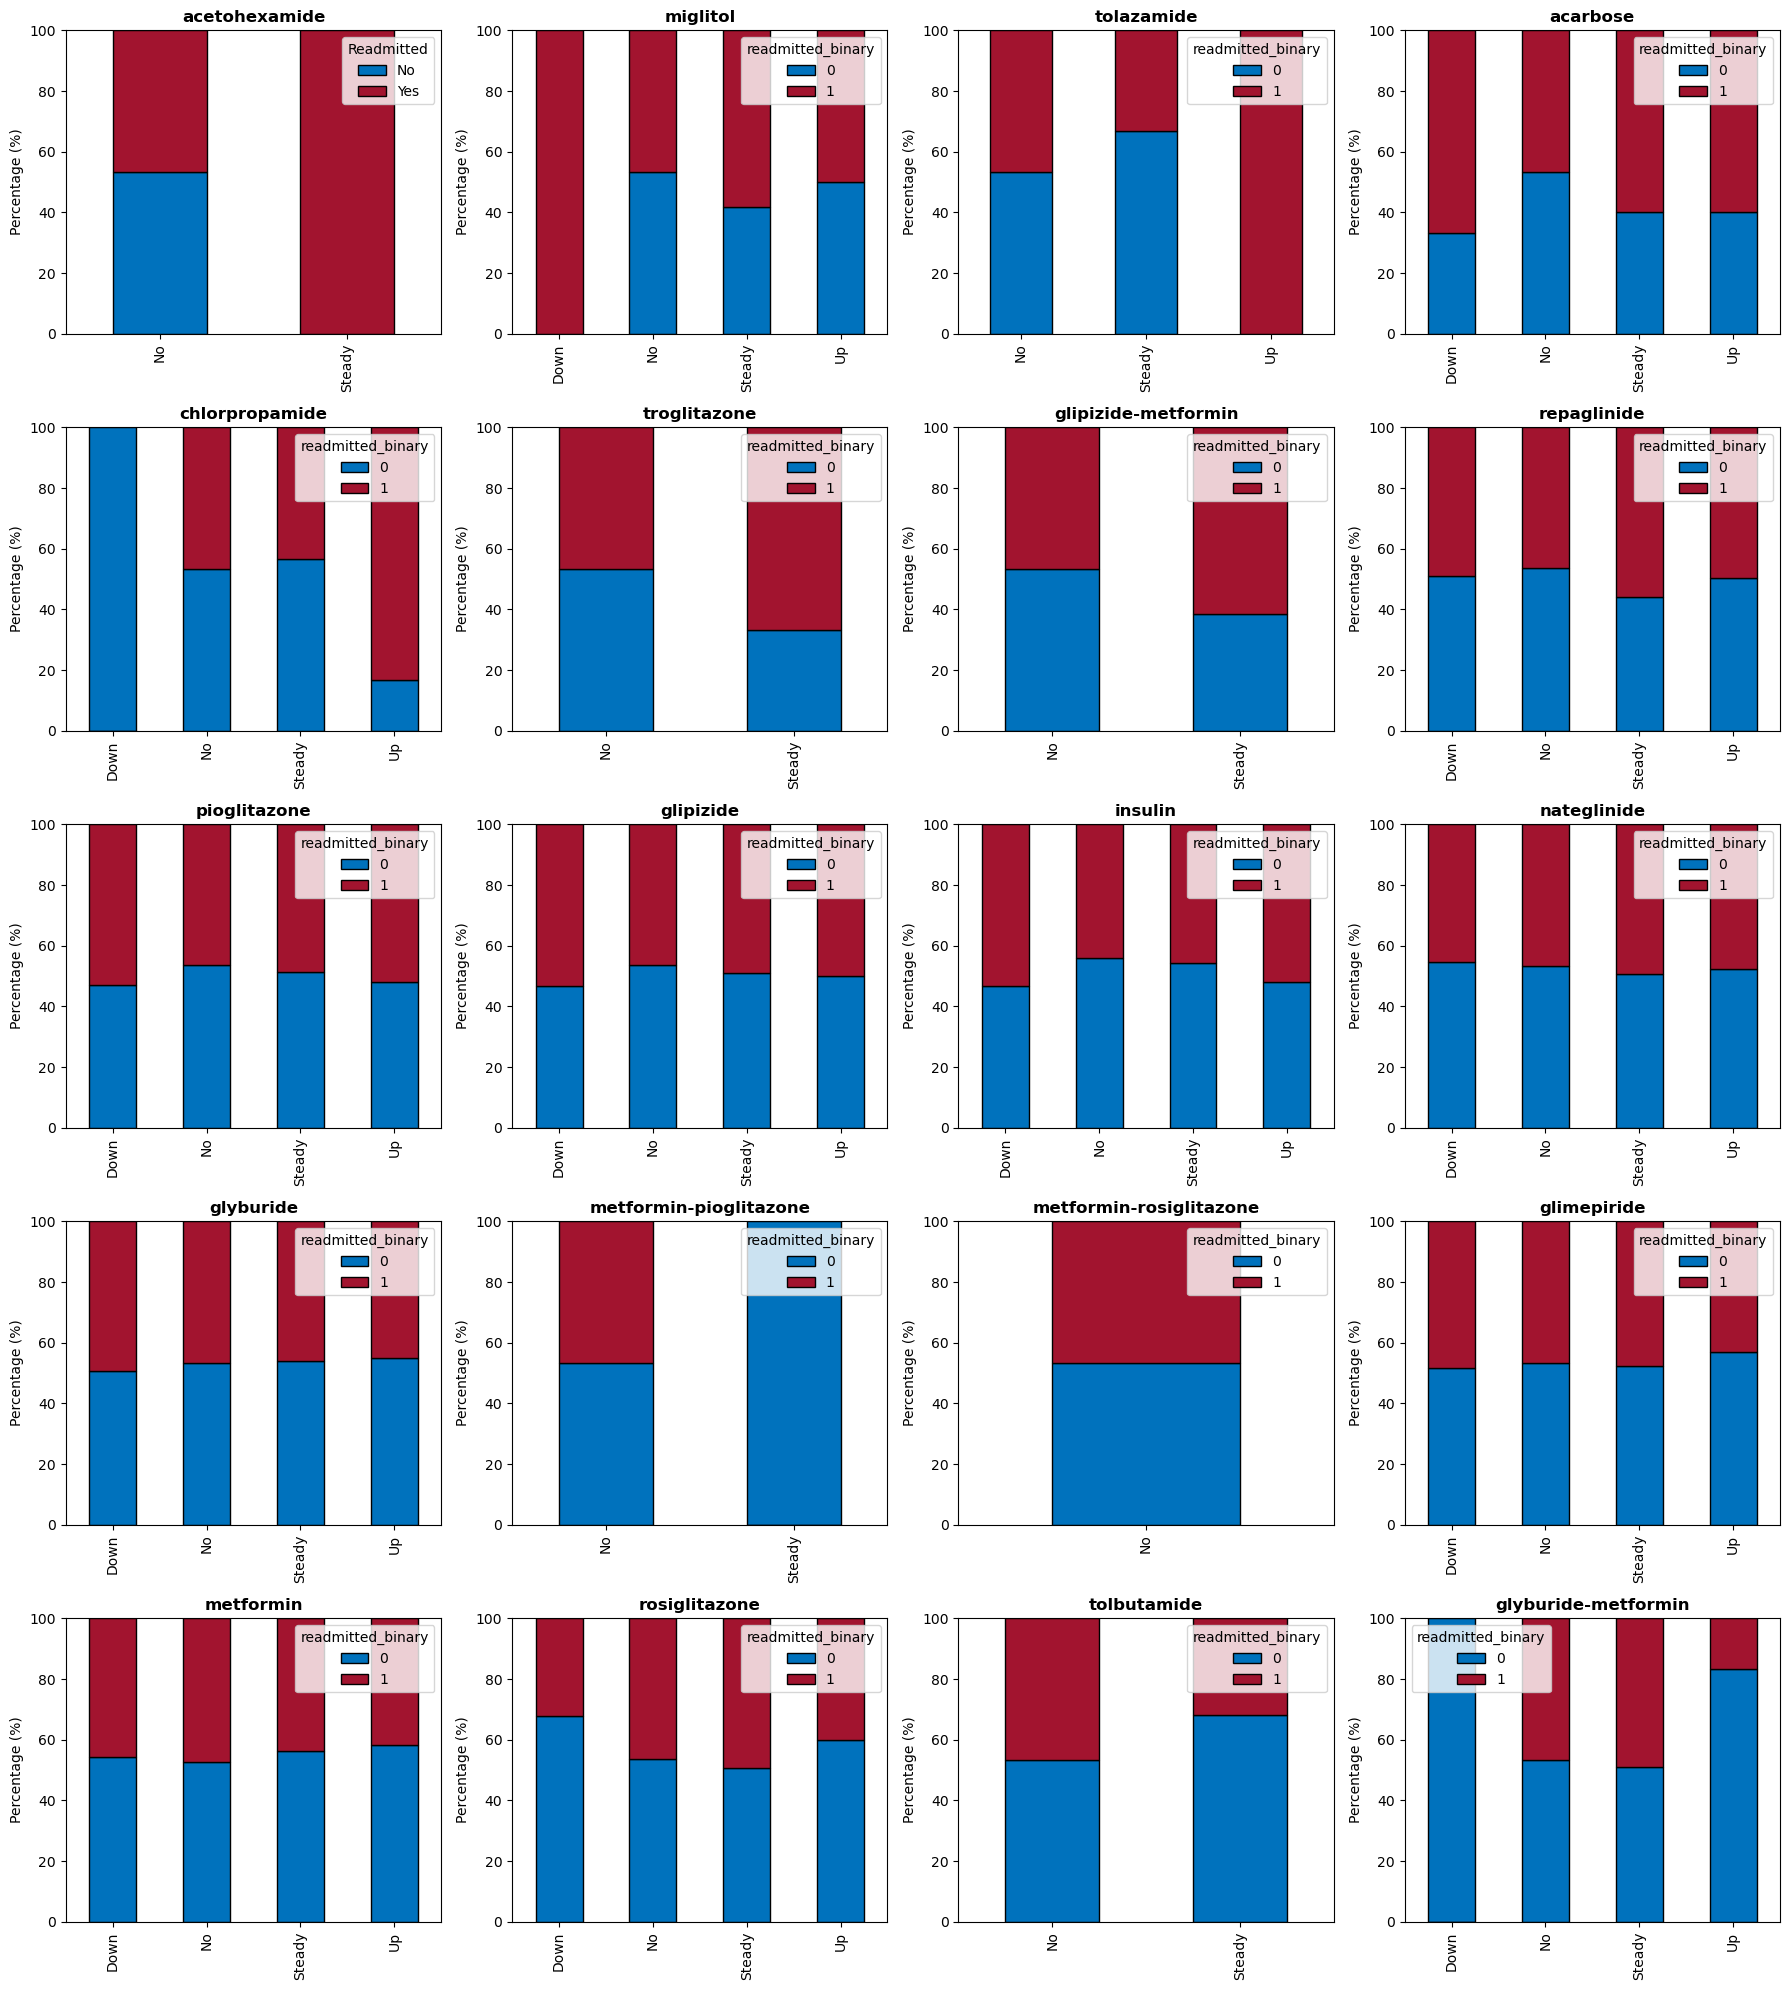

In [46]:
# Compute readmission percentage for each drug
drug_readmit_rates = {}
for drug in drug_cols:
    drug_counts = data.groupby([drug, 'readmitted_binary']).size().unstack()
    drug_percent = drug_counts.div(drug_counts.sum(axis=1), axis=0) * 100
    avg_readmit_rate = drug_percent[1].mean()  # Avg. percentage of readmitted
    drug_readmit_rates[drug] = avg_readmit_rate

# Sort drugs by highest readmission percentage
sorted_drugs = sorted(drug_readmit_rates, key=drug_readmit_rates.get, reverse=True)

# Create subplots with sorted drug distributions
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 20))  
axes = axes.flatten()  

# Loop through sorted drugs and plot on subplots
for idx, drug in enumerate(sorted_drugs):
    drug_counts = data.groupby([drug, 'readmitted_binary']).size().unstack()
    drug_percent = drug_counts.div(drug_counts.sum(axis=1), axis=0) * 100  
    
    # Plot as stacked bar chart
    drug_percent.plot(kind='bar', stacked=True, ax=axes[idx], color=["#0072BD", "#A2142F"], edgecolor="black")

    # Formatting
    axes[idx].set_title(drug, fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].set_ylim(0, 100)

    # Move legend outside to avoid overlap
    if idx == 0:
        axes[idx].legend(title="Readmitted", labels=["No", "Yes"], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

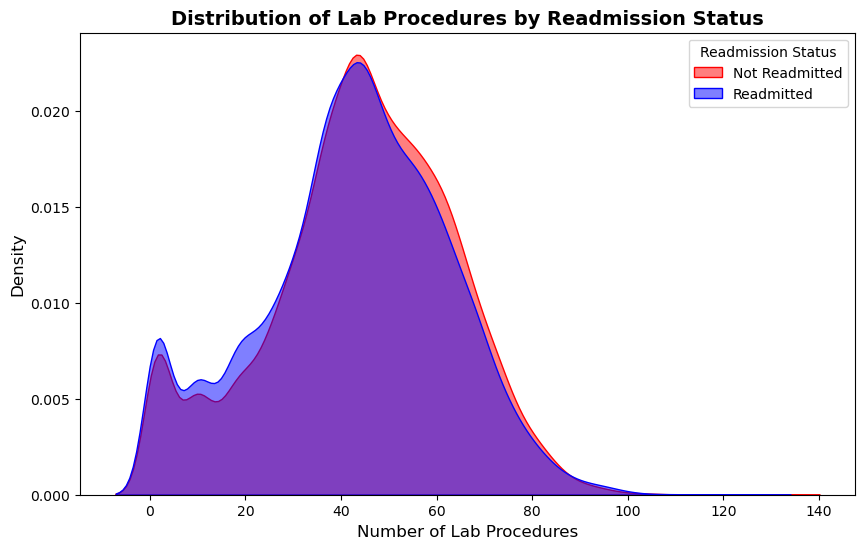

In [47]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted
sns.kdeplot(data=data, x="num_lab_procedures", hue="readmitted_binary",
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2)

# Labels & Title
plt.xlabel("Number of Lab Procedures", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Lab Procedures by Readmission Status", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

# Show plot
plt.show()


In [48]:
n_admissions = data['encounter_id'].nunique()
n_patients = data['patient_nbr'].nunique()

admissions_per_patient = data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

print(f"Proportion of patients that have multiple admissions: {multiple_admissions['patient_nbr'].nunique()/n_patients:.2%}")
print(f"Maximum number of admissions for a given patient: {multiple_admissions['count'].max()}")

Proportion of patients that have multiple admissions: 23.72%
Maximum number of admissions for a given patient: 39


In [49]:
# Unique admissions & patients
n_admissions = data['encounter_id'].nunique()
n_patients = data['patient_nbr'].nunique()

# Count admissions per patient
admissions_per_patient = data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']

# Identify patients with multiple admissions
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

# Compute additional insights
multiple_admission_rate = multiple_admissions['patient_nbr'].nunique() / n_patients
max_admissions = multiple_admissions['count'].max()


# Display key statistics
print("="*50)
print(f"Total Admissions: {n_admissions:,}")
print(f"Total Unique Patients: {n_patients:,}")
print(f"Proportion of Patients with Multiple Admissions: {multiple_admission_rate:.2%}")
print(f"Maximum Number of Admissions for a Single Patient: {max_admissions}")
print("="*50)


Total Admissions: 98,052
Total Unique Patients: 68,629
Proportion of Patients with Multiple Admissions: 23.72%
Maximum Number of Admissions for a Single Patient: 39


## Feature Engeniering

### Remapping Categorical values

In [50]:
numerical_columns = list(data.select_dtypes(include=['number']).columns)
categorical_columns =   data.select_dtypes(include='object').columns

In [51]:
# Encoding categorical variables for model input

## Gender Encoding
gender_mapping = {
    'Male': 0, 
    'Female': 1
}
data['gender'] = data['gender'].map(gender_mapping)

## Race Encoding
race_mapping = {
    'Caucasian': 0, 
    'AfricanAmerican': 1, 
    'Hispanic': 2, 
    'Other': 3, 
    'Asian': 4
}
data['race'] = data['race'].map(race_mapping)

## Change Column Encoding
change_mapping = {
    'No': 0, 
    'Ch': 1
}
data['change'] = data['change'].map(change_mapping)

## Diabetes Medication Encoding
diabetesMed_mapping = {
    'No': 0, 
    'Yes': 1
}
data['diabetesMed'] = data['diabetesMed'].map(diabetesMed_mapping)

## Age Group Encoding (Labels for Classification)
age_mapping = {
    '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, 
    '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9
}
data['age_label'] = data['age'].map(age_mapping)

# Convert to NumPy array for model input
age_input = np.array(data['age_label'])  

## Max Glucose Serum Encoding
max_glu_serum_map = {
    '0': 0,       
    'Norm': 1, 
    '>200': 2, 
    '>300': 3
}
data['max_glu_serum'] = data['max_glu_serum'].astype(str).map(max_glu_serum_map)

## A1C Result Encoding
A1Cresult_map = {
    '0': 0,      
    'Norm': 1, 
    '>7': 2, 
    '>8': 3
}
data['A1Cresult'] = data['A1Cresult'].astype(str).map(A1Cresult_map)

In [52]:
# List of drug columns
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
             'metformin-rosiglitazone', 'metformin-pioglitazone','examide', 'citoglipton', 'glimepiride-pioglitazone']

# Dictionary to store label encoders for future decoding
drug_label_encoders = {}

# Convert categorical drug columns to numeric labels
for col in drug_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # Apply encoding
    drug_label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Store mapping


### Creating new features

In [53]:
#categorize ICD-9 codes into disease categories
data['diag_1_category'] = data['diag_1'].apply(categorize_icd9)
data['diag_2_category'] = data['diag_2'].apply(categorize_icd9)
data['diag_3_category'] = data['diag_3'].apply(categorize_icd9)

In [54]:
# creating a number of visits column

data['num_visits'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']

In [55]:
# labling categorized ICD-9 codes
# List of drug columns
diag_cols = ['diag_1_category', 'diag_2_category', 'diag_3_category']

# Dictionary to store label encoders for future decoding
diag_cols_encoders = {}

# Convert categorical drug columns to numeric labels
for col in diag_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col]) 
    diag_cols_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [56]:
# Ensure required columns exist in DataFrame before proceeding
existing_columns = set(data.columns)

# Define interaction terms (Only keep valid ones)
datainteractionterms = [
    ('num_medications', 'time_in_hospital'),
    ('num_medications', 'num_procedures'),
    ('time_in_hospital', 'num_lab_procedures'),
    ('num_medications', 'num_lab_procedures'),
    ('num_medications', 'number_diagnoses'),
    ('change', 'num_medications'),
    ('number_diagnoses', 'time_in_hospital'),
    ('num_medications', 'num_visits')  
]

# Filter interaction terms to keep only existing columns
valid_interaction_terms = [(col1, col2) for col1, col2 in datainteractionterms if col1 in existing_columns and col2 in existing_columns]
# Ensure all relevant columns are numeric
for col1, col2 in valid_interaction_terms:
    data[col1] = pd.to_numeric(data[col1], errors='coerce')
    data[col2] = pd.to_numeric(data[col2], errors='coerce')

# Generate interaction terms
for col1, col2 in valid_interaction_terms:
    name = col1 + '|' + col2
    
    # Multiplication
    new_col_mult = name + '_mult'
    data[new_col_mult] = data[col1] * data[col2]
    numerical_columns.append(new_col_mult)

    # Addition
    new_col_sum = name + '_sum'
    data[new_col_sum] = data[col1] + data[col2]
    numerical_columns.append(new_col_sum)

    # Division (Avoiding division by zero)
    new_col_ratio = name + '_ratio'
    data[new_col_ratio] = data[col1] / (data[col2] + 1e-5)
    numerical_columns.append(new_col_ratio)

# Remove duplicate column names in numerical_columns
numerical_columns = list(set(numerical_columns))

# Generate Polynomial Features
data['num_medications_squared'] = data['num_medications'] ** 2
data['time_in_hospital_squared'] = data['time_in_hospital'] ** 2
data['number_diagnoses_squared'] = data['number_diagnoses'] ** 2

# Add polynomial features to numerical_columns
numerical_columns.extend(['num_medications_squared', 'time_in_hospital_squared', 'number_diagnoses_squared'])

# Generate Healthcare Utilization Ratios
data['num_medications_time_in_hospital_ratio'] = data['num_medications'] / (data['time_in_hospital'] + 1e-5)
data['num_medications_num_lab_procedures_ratio'] = data['num_medications'] / (data['num_lab_procedures'] + 1e-5)
data['number_diagnoses_time_in_hospital_ratio'] = data['number_diagnoses'] / (data['time_in_hospital'] + 1e-5)

# Add ratio features to numerical_columns
numerical_columns.extend(['num_medications_time_in_hospital_ratio', 'num_medications_num_lab_procedures_ratio', 'number_diagnoses_time_in_hospital_ratio'])

# Ensure numerical_columns does not have duplicates
numerical_columns = list(set(numerical_columns))

# Display object columns (if any exist)
object_columns = data[numerical_columns].select_dtypes('object')



### checking if new features are statistically significant

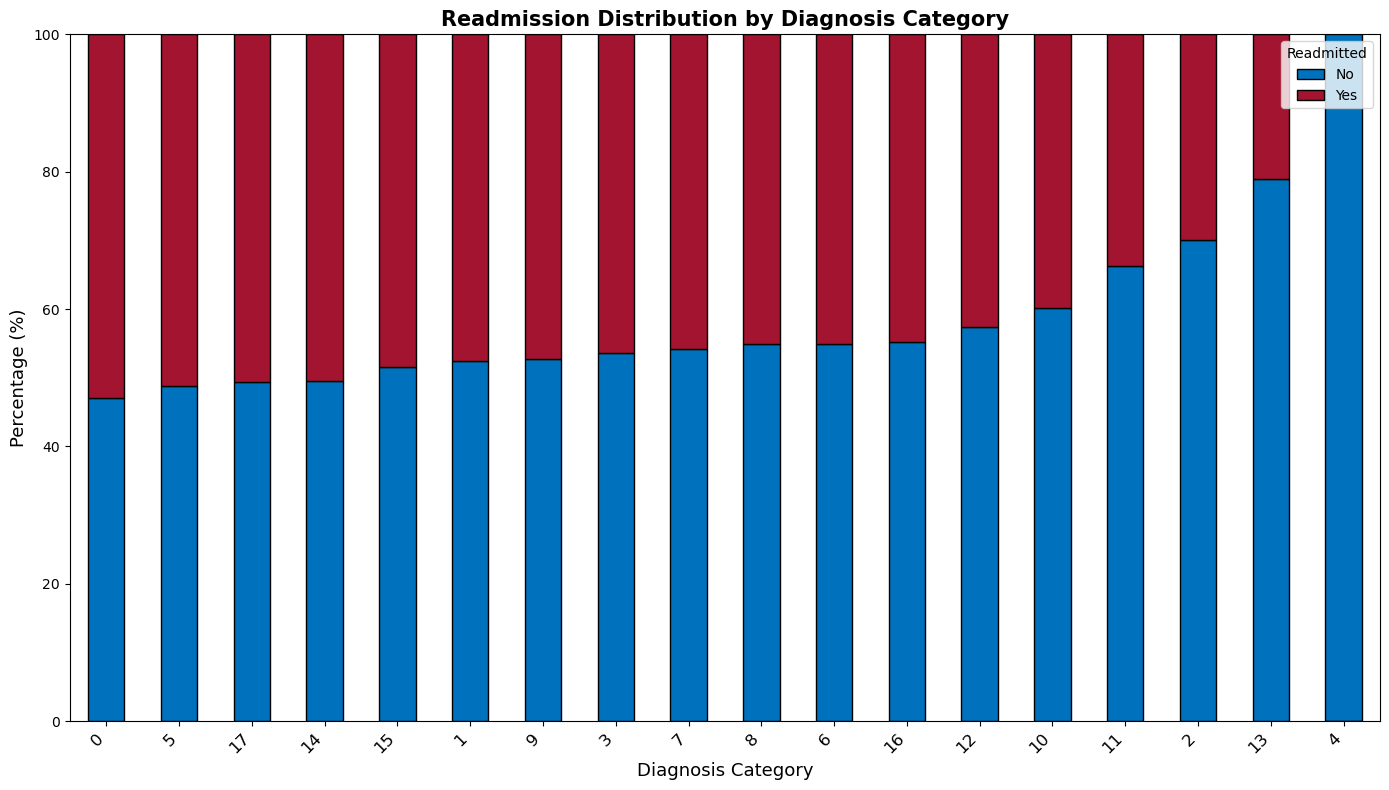

In [57]:
# Compute readmission percentage for each diagnosis category in diag_1_category
diag_category_counts = data.groupby(['diag_1_category', 'readmitted_binary']).size().unstack()

# Compute percentages
diag_category_percent = diag_category_counts.div(diag_category_counts.sum(axis=1), axis=0) * 100

# Compute the average readmission rate per diagnosis category
diag_category_readmit_rates = diag_category_percent[1].fillna(0).to_dict()

# Sort categories by highest readmission percentage
sorted_diag_categories = sorted(diag_category_readmit_rates, key=diag_category_readmit_rates.get, reverse=True)

# Create figure for subplots
fig, ax = plt.subplots(figsize=(14, 8))

# Plot stacked bar chart for diagnosis categories
diag_category_percent.loc[sorted_diag_categories].plot(kind='bar', stacked=True, ax=ax, 
                                                       color=["#0072BD", "#A2142F"], edgecolor="black")

# Formatting
ax.set_title("Readmission Distribution by Diagnosis Category", fontsize=15, fontweight="bold")
ax.set_xlabel("Diagnosis Category", fontsize=13)
ax.set_ylabel("Percentage (%)", fontsize=13)
ax.set_ylim(0, 100)  # Ensure consistent scaling
ax.legend(title="Readmitted", labels=["No", "Yes"], loc='upper right')

# Improve x-axis readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


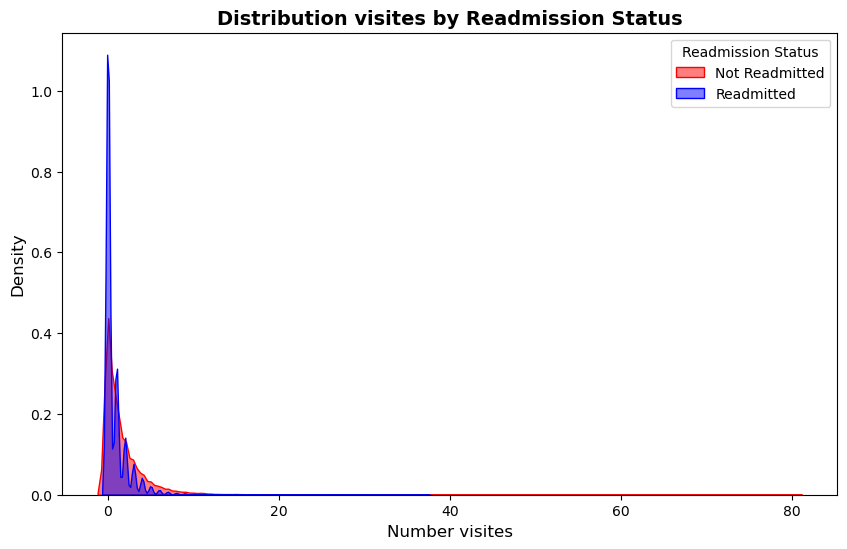

In [58]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted
sns.kdeplot(data=data, x="num_visits", hue="readmitted_binary",
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2)

# Labels & Title
plt.xlabel("Number visites", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution visites by Readmission Status", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

# Show plot
plt.show()


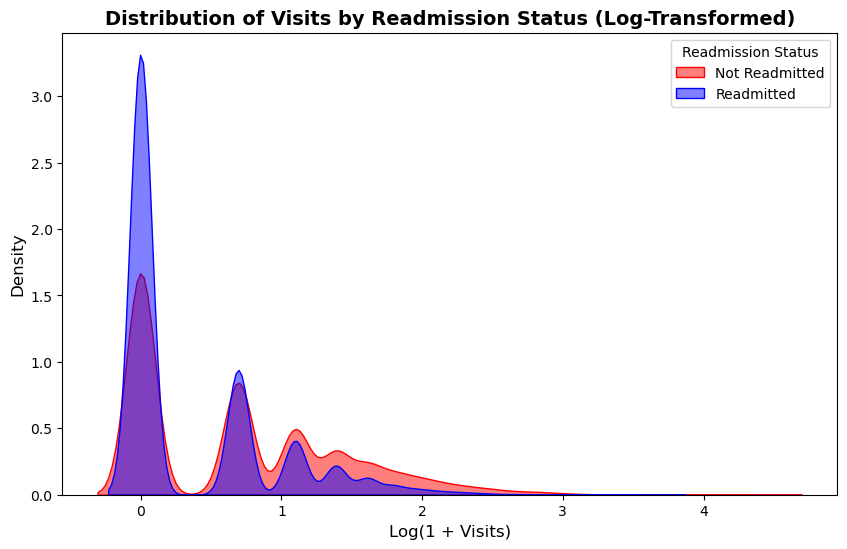

In [59]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted & Readmitted, applying log transformation on-the-fly
sns.kdeplot(data=data, 
            x=np.log1p(data['num_visits']), 
            hue=data['readmitted_binary'],
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2) 

# Labels & Title
plt.xlabel("Log(1 + Visits)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Visits by Readmission Status (Log-Transformed)", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

plt.show()


In [60]:
from scipy.stats import mannwhitneyu

# Apply log transformation dynamically
readmitted_visits = np.log1p(data[data['readmitted_binary'] == 1]['num_visits'])
not_readmitted_visits = np.log1p(data[data['readmitted_binary'] == 0]['num_visits'])

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(readmitted_visits, not_readmitted_visits, alternative='greater')

# Print results
print("Mann-Whitney U Test Results:")
print(f"Statistic = {stat:.4f}, P-value = {p_value:.4e}")

if p_value < 0.05:
    print("P-value < 0.05: Reject Null Hypothesis (Significant Difference)")
else:
    print("P-value >= 0.05: Fail to Reject Null Hypothesis (No Significant Difference)")


Mann-Whitney U Test Results:
Statistic = 1496453014.5000, P-value = 0.0000e+00
P-value < 0.05: Reject Null Hypothesis (Significant Difference)


since p<0.05 it confirms that the number of visits is significantly different between readmitted and non-readmitted patients.

### **Log Transformation Analysis**

#### **Objective**
We assess numerical features to determine if log transformation is needed to improve distribution and reduce skewness.

#### **Process**
1. **Check Skewness & Kurtosis**  
   - If both values are high, the feature is likely skewed.

2. **Apply Log Transformation When Necessary**  
   - `log` is used when zero values are minimal.  
   - `log1p` is used when zero values are present.

3. **Evaluate Transformation Impact**  
   - Compare skewness and kurtosis before and after transformation.  
   - Perform a **p-value test** to measure statistical significance.

4. **Decision Making**  
   - If transformation improves distribution (**p-value < 0.05**), it is applied.  
   - Otherwise, the feature remains unchanged.

In [61]:
# Ensure numerical_columns is a list
numerical_columns = list(numerical_columns)  

# Append 'num_visits' column if not already present
if 'num_visits' not in numerical_columns:
    numerical_columns.append('num_visits')

# Initialize list to store results
data_records = []

# Iterate through numerical columns
for col in numerical_columns:
    skew_before = data[col].skew()
    kurt_before = data[col].kurtosis()
    std_before = data[col].std()

    log_needed = 'No'
    log_method = 'NA'
    skew_after = skew_before
    kurt_after = kurt_before
    std_after = std_before
    p_value = np.nan  # Default NaN if no transformation applied

    # Apply log transformation if skewness and kurtosis exceed thresholds
    if abs(skew_before) > 2 and abs(kurt_before) > 2:
        log_needed = 'Yes'

        if (data[col] == 0).sum() / len(data) <= 0.02:
            log_method = 'log'
            transformed = np.log(data[col][data[col] > 0])  
        else:
            log_method = 'log1p'
            transformed = np.log1p(data[col])  

        # Store new stats after transformation
        skew_after = transformed.skew()
        kurt_after = transformed.kurtosis()
        std_after = transformed.std()

        # Perform Mann-Whitney U test to check distribution shift
        stat, p_val = mannwhitneyu(data[col].dropna(), transformed.dropna(), alternative='two-sided')
        p_value = f"{p_val:.2e}"

    # Append results to list
    data_records.append([col, skew_before, kurt_before, std_before, log_needed, 
                         log_method, skew_after, kurt_after, std_after, p_value])

# Create DataFrame from records
statdataframe = pd.DataFrame(data_records, columns=[
    'Feature', 'Skew Before', 'Kurtosis Before', 'Std Dev Before', 
    'Log Transform Needed', 'Log Type', 'Skew After', 'Kurtosis After', 
    'Std Dev After', 'P-Value'
])

# Format P-Value column
statdataframe['P-Value'] = statdataframe['P-Value'].apply(lambda x: f"{x}" if x != np.nan else "NaN")

# Display DataFrame in a better format

display(statdataframe.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4A90E2'), ('color', 'white'), ('text-align', 'center')]},
    {'selector': 'tbody td', 'props': [('text-align', 'center')]}
]).set_properties(**{'font-size': '12px'}))


,Feature,Skew Before,Kurtosis Before,Std Dev Before,Log Transform Needed,Log Type,Skew After,Kurtosis After,Std Dev After,P-Value
0,num_medications|num_procedures_mult,3.037934,12.610668,44.964414,Yes,log1p,0.148012,-1.589548,1.876871,0.00e+00
1,number_inpatient,3.554811,19.943138,1.271025,Yes,log1p,1.416796,1.290196,0.514047,6.06e-154
2,num_medications|time_in_hospital_ratio,2.208681,6.936957,3.824964,Yes,log,0.033700,0.219488,0.668235,0.00e+00
3,number_diagnoses|time_in_hospital_mult,1.270311,1.336267,26.330262,No,NA,1.270311,1.336267,26.330262,nan
4,number_diagnoses,-0.817531,-0.345022,1.832472,No,NA,-0.817531,-0.345022,1.832472,nan
5,num_medications|number_diagnoses_mult,1.282764,3.142963,74.769482,No,NA,1.282764,3.142963,74.769482,nan
6,num_medications|num_visits_mult,5.879785,67.825923,44.674241,Yes,log1p,0.485509,-1.357391,1.807217,0.00e+00
7,num_medications_squared,3.963866,26.500431,371.338427,Yes,log,-0.724760,1.835274,1.063901,0.00e+00
8,num_medications|num_procedures_sum,1.362323,3.514631,8.903751,No,NA,1.362323,3.514631,8.903751,nan
9,time_in_hospital_squared,2.288521,5.394884,38.206172,Yes,log,-0.212844,-0.705098,1.423091,0.00e+00


In [62]:
# Create a copy of the dataset to apply transformations
log_transformed_data = data.copy()

# Iterate through the transformation DataFrame
for index, row in statdataframe.iterrows():
    col = row['Feature']
    
    if row['Log Transform Needed'] == 'Yes':
        if row['Log Type'] == 'log':
            log_transformed_data[col] = np.log(log_transformed_data[col].replace(0, np.nan))  
        elif row['Log Type'] == 'log1p':
            log_transformed_data[col] = np.log1p(log_transformed_data[col])


In [63]:
# Sort data by patient ID and encounter date
data_sorted = log_transformed_data.sort_values(by=['patient_nbr', 'encounter_id'])

# Keep only the first encounter for each patient
collapsed_data = data_sorted.drop_duplicates(subset=['patient_nbr'], keep='first')

# Compute the total number of encounters for each patient
encounter_counts = log_transformed_data['patient_nbr'].value_counts().reset_index()
encounter_counts.columns = ['patient_nbr', 'total_encounters']

# Merge total encounters back to the collapsed dataset
collapsed_data = collapsed_data.merge(encounter_counts, on='patient_nbr', how='left')

# Display summary
print(f"Original dataset size: {len(log_transformed_data):,}")
print(f"Collapsed dataset size: {len(collapsed_data):,}")
print(f"Patients with multiple encounters (before collapsing): {(encounter_counts['total_encounters'] > 1).sum():,}")

# Display the updated dataset
collapsed_data


Original dataset size: 98,052
Collapsed dataset size: 68,629
Patients with multiple encounters (before collapsing): 16,280


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,num_medications|num_visits_mult,num_medications|num_visits_sum,num_medications|num_visits_ratio,num_medications_squared,time_in_hospital_squared,number_diagnoses_squared,num_medications_time_in_hospital_ratio,num_medications_num_lab_procedures_ratio,number_diagnoses_time_in_hospital_ratio,total_encounters
0,24437208,135,0,1,[50-60),2,0.000000,1,8,77,...,0.0,33,3300000.0,6.993015,4.158883,64,1.417065,-0.847298,0.999999,2
1,29758806,378,0,1,[50-60),3,0.000000,1,2,49,...,0.0,11,1100000.0,4.795791,1.386294,9,1.704743,-1.493925,1.499993,1
2,189899286,729,0,1,[80-90),1,1.098612,7,4,68,...,0.0,23,2300000.0,6.270988,2.772589,81,1.749197,-1.084014,2.249994,1
3,64331490,774,0,1,[80-90),1,0.000000,7,3,46,...,0.0,20,2000000.0,5.991465,2.197225,81,1.897117,-0.832909,2.999990,1
4,14824206,927,1,1,[30-40),1,0.000000,7,5,49,...,0.0,5,500000.0,3.218876,3.218876,9,-0.000002,-2.282383,0.599999,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68624,418513058,189351095,0,1,[80-90),1,0.000000,7,1,73,...,0.0,11,1100000.0,4.795791,0.000000,81,2.397885,-1.892564,8.999910,1
68625,359719064,189365864,3,0,[60-70),1,0.000000,7,3,56,...,0.0,8,800000.0,4.158883,2.197225,49,0.980826,-1.945910,2.333326,1
68626,338462954,189445127,0,1,[80-90),1,0.000000,7,3,39,...,0.0,18,1800000.0,5.780744,2.197225,81,1.791756,-0.773190,2.999990,1
68627,443811536,189481478,0,1,[40-50),1,1.386294,7,14,69,...,0.0,16,1600000.0,5.545177,5.278115,25,0.133531,-1.461518,0.357143,1


### Model

In [64]:
feature_set = [
    'race', 'gender',
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses',
    'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
    'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed',
    'age_label', 'diag_1_category', 'diag_2_category',
    'diag_3_category', 'num_visits', 'total_encounters',

    # Interaction Terms (Multiplication, Sum, and Ratio)
    'num_medications|time_in_hospital_mult', 'num_medications|time_in_hospital_sum', 'num_medications|time_in_hospital_ratio',
    'num_medications|num_procedures_mult', 'num_medications|num_procedures_sum', 'num_medications|num_procedures_ratio',
    'time_in_hospital|num_lab_procedures_mult', 'time_in_hospital|num_lab_procedures_sum', 'time_in_hospital|num_lab_procedures_ratio',
    'num_medications|num_lab_procedures_mult', 'num_medications|num_lab_procedures_sum', 'num_medications|num_lab_procedures_ratio',
    'num_medications|number_diagnoses_mult', 'num_medications|number_diagnoses_sum', 'num_medications|number_diagnoses_ratio',
    'change|num_medications_mult', 'change|num_medications_sum', 'change|num_medications_ratio',
    'number_diagnoses|time_in_hospital_mult', 'number_diagnoses|time_in_hospital_sum', 'number_diagnoses|time_in_hospital_ratio',
    'num_medications|num_visits_mult', 'num_medications|num_visits_sum', 'num_medications|num_visits_ratio',

    # Polynomial Features
    'num_medications_squared', 'time_in_hospital_squared', 'number_diagnoses_squared',

    # Healthcare Utilization Ratios
    'num_medications_time_in_hospital_ratio', 'num_medications_num_lab_procedures_ratio', 'number_diagnoses_time_in_hospital_ratio'
]


In [65]:
X = collapsed_data[feature_set]
y = collapsed_data['readmitted_binary']

In [ ]:
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Feature Selection with Grid Search

In [71]:
# Ensure feature_set exists in collapsed_data
missing_features = [col for col in feature_set if col not in collapsed_data.columns]
if missing_features:
    print("Warning! Missing Features:", missing_features)

# Define feature matrix and target variable
X = collapsed_data[feature_set]
y = collapsed_data['readmitted_binary']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [10, 15, 20, 28, 35],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10], 
    'max_features': ['sqrt', 'log2', None]  
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Accuracy from Grid Search: {grid_search.best_score_:.4f}")

# Train the best model on full training data
best_dtree = grid_search.best_estimator_
best_dtree.fit(X_train, y_train)

# Make predictions
y_pred = best_dtree.predict(X_test)

# Evaluate performance
print("\nOptimized Model Performance:")
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Optimized Precision: {precision_score(y_test, y_pred, average='binary'):.4f}")
print(f"Optimized Recall: {recall_score(y_test, y_pred, average='binary'):.4f}")
print(f"Optimized F1 Score: {f1_score(y_test, y_pred, average='binary'):.4f}")
print(f"Optimized ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Display a full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 480 candidates, totalling 2400 fits

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 30}
Best Accuracy from Grid Search: 0.8261

Optimized Model Performance:
Optimized Accuracy: 0.8344
Optimized Precision: 0.9202
Optimized Recall: 0.6465
Optimized F1 Score: 0.7594
Optimized ROC-AUC Score: 0.8042

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      8176
           1       0.92      0.65      0.76      5550

    accuracy                           0.83     13726
   macro avg       0.86      0.80      0.82     13726
weighted avg       0.85      0.83      0.83     13726



### Selecting Features with high importance

In [72]:
importances = best_dtree.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(50))


                                      Feature  Importance
45                           total_encounters    0.788634
11                           number_inpatient    0.077196
3                    discharge_disposition_id    0.029259
2                           admission_type_id    0.012916
67            num_medications|num_visits_mult    0.011740
72                   number_diagnoses_squared    0.008668
6                          num_lab_procedures    0.007548
55    num_medications|num_lab_procedures_mult    0.004843
40                                  age_label    0.004639
51       num_medications|num_procedures_ratio    0.003951
4                         admission_source_id    0.003951
13                              max_glu_serum    0.003530
74   num_medications_num_lab_procedures_ratio    0.002715
39                                diabetesMed    0.002686
52   time_in_hospital|num_lab_procedures_mult    0.002269
60     num_medications|number_diagnoses_ratio    0.002042
54  time_in_ho

In [73]:
# Define threshold for feature importance
threshold = 0.001  

# Filter out low-importance features
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()

# Print feature selection summary
print(f"\n Number of Selected Features: {len(important_features)}")
print(f" Removed {len(feature_importance_df) - len(important_features)} features with importance < {threshold}.")

# Keep only important features
X_train_filtered = X_train[important_features].copy()
X_test_filtered = X_test[important_features].copy()




 Number of Selected Features: 35
 Removed 41 features with importance < 0.001.


In [74]:
# Keep only important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

#### First Decision Tree

In [77]:
# Train Decision Tree with selected features
dtree = DecisionTreeClassifier(max_depth=28, criterion="entropy", min_samples_split=10)
dtree.fit(X_train_filtered, y_train)

# Make predictions
y_pred_filtered = dtree.predict(X_test_filtered)

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_test, y_pred_filtered):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_filtered, average='binary'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_filtered, average='binary'):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_filtered, average='binary'):.3f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_filtered):.3f}")

Accuracy: 0.787
Precision: 0.757
Recall: 0.696
F1 Score: 0.725
ROC-AUC Score: 0.772


### Training Random Forest Classifier

In [104]:
# Retrain the model with optimized feature set
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_filtered, y_train)

# Predictions
y_pred = model.predict(X_test_filtered)

# Evaluate Performance
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Optimized Precision: {precision_score(y_test, y_pred, average='binary'):.3f}")
print(f"Optimized Recall: {recall_score(y_test, y_pred, average='binary'):.3f}")
print(f"Optimized F1 Score: {f1_score(y_test, y_pred, average='binary'):.3f}")
print(f"Optimized ROC-AUC Score: {roc_auc_score(y_test, y_pred):.3f}")

Optimized Accuracy: 0.837
Optimized Precision: 0.933
Optimized Recall: 0.643
Optimized F1 Score: 0.761
Optimized ROC-AUC Score: 0.806


### Training XGBoost

In [ ]:
xgb = XGBClassifier(n_estimators=200, max_depth=10, scale_pos_weight=2) 
xgb.fit(X_train_filtered, y_train)

y_pred_xgb = xgb.predict(X_test_filtered)

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(f"XGBoost Precision: {precision_score(y_test, y_pred_xgb):.3f}")
print(f"XGBoost Recall: {recall_score(y_test, y_pred_xgb):.3f}")
print(f"XGBoost F1 Score: {f1_score(y_test, y_pred_xgb):.3f}")
print(f"XGBoost ROC-AUC Score: {roc_auc_score(y_test, y_pred_xgb):.3f}")

XGBoost Accuracy: 0.814
XGBoost Precision: 0.806
XGBoost Recall: 0.710
XGBoost F1 Score: 0.755
XGBoost ROC-AUC Score: 0.797


### Training Logistic Regression

In [103]:
# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Define Logistic Regression Model with Increased Iterations
logit = LogisticRegression(
    penalty='l2', 
    solver='lbfgs', 
    max_iter=2000, 
    class_weight='balanced',
    random_state=42
)

# Train the Model
logit.fit(X_train_scaled, y_train)

# Predictions
y_pred_logit = logit.predict(X_test_scaled)

# Evaluate Performance
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logit):.3f}")
print(f"Logistic Regression Precision: {precision_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"Logistic Regression Recall: {recall_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"Logistic Regression F1 Score: {f1_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"Logistic Regression ROC-AUC Score: {roc_auc_score(y_test, y_pred_logit):.3f}")

Logistic Regression Accuracy: 0.836
Logistic Regression Precision: 0.893
Logistic Regression Recall: 0.674
Logistic Regression F1 Score: 0.768
Logistic Regression ROC-AUC Score: 0.810


### Neural Network

In [82]:
# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)


In [83]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:
# Compile the model before training
model.compile(
    optimizer=Adam(learning_rate=0.0005),  
    loss='binary_crossentropy', 
    metrics=['accuracy', Precision(), Recall()]
)

# Now fit the model
history = model.fit(
    X_train_scaled, y_train, 
    epochs=100, 
    batch_size=64,  
    validation_data=(X_test_scaled, y_test),
    verbose=1
)



Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7229 - loss: 0.5656 - precision: 0.6885 - recall: 0.5920 - val_accuracy: 0.8386 - val_loss: 0.3915 - val_precision: 0.9161 - val_recall: 0.6613
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.8242 - loss: 0.4158 - precision: 0.8867 - recall: 0.6479 - val_accuracy: 0.8372 - val_loss: 0.3805 - val_precision: 0.9309 - val_recall: 0.6452
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.8272 - loss: 0.4020 - precision: 0.8985 - recall: 0.6415 - val_accuracy: 0.8388 - val_loss: 0.3778 - val_precision: 0.9245 - val_recall: 0.6550
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.8283 - loss: 0.3982 - precision: 0.9084 - recall: 0.6432 - val_accuracy: 0.8383 - val_loss: 0.3772 - val_precision: 0.9574 - val_recall: 0.6281
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8273 - loss: 0.3964 - precision: 0.9150 - recall: 0.6337 - val_accuracy: 0.8388 - v

In [85]:
# Evaluate performance
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)

print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network Precision: {precision_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network Recall: {recall_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network F1 Score: {f1_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network ROC-AUC Score: {roc_auc_score(y_test, y_pred_nn):.3f}")

429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
Neural Network Accuracy: 0.836
Neural Network Precision: 0.907
Neural Network Recall: 0.662
Neural Network F1 Score: 0.765
Neural Network ROC-AUC Score: 0.808


In [86]:
from sklearn.utils.class_weight import compute_class_weight

# Ensure y_train is a NumPy array
y_train_np = np.array(y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_np), 
    y=y_train_np
)

# Convert class weights to dictionary
class_weights = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weights)


Computed Class Weights: {0: 0.8394184019814696, 1: 1.236554054054054}


In [87]:
y_train_np = y_train_np.astype(int)


In [88]:
history = model.fit(
    X_train_scaled, y_train_np, 
    epochs=100, batch_size=64,
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8396 - loss: 0.3776 - precision: 0.8626 - recall: 0.7132 - val_accuracy: 0.8324 - val_loss: 0.3896 - val_precision: 0.8622 - val_recall: 0.6969
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.8369 - loss: 0.3806 - precision: 0.8584 - recall: 0.7161 - val_accuracy: 0.8281 - val_loss: 0.3939 - val_precision: 0.8403 - val_recall: 0.7099
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - accuracy: 0.8348 - loss: 0.3776 - precision: 0.8493 - recall: 0.7193 - val_accuracy: 0.8258 - val_loss: 0.3970 - val_precision: 0.8302 - val_recall: 0.7155
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.8337 - loss: 0.3813 - precision: 0.8479 - recall: 0.7206 - val_accuracy: 0.8276 - val_loss: 0.3955 - val_precision: 0.8346 - val_recall: 0.7153
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.8381 - loss: 0.3733 - precision: 0.8544 - recall: 0.7243 - val_accuracy: 0.8294 -

In [89]:
# Evaluate performance
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)

print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network Precision: {precision_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network Recall: {recall_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network F1 Score: {f1_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network ROC-AUC Score: {roc_auc_score(y_test, y_pred_nn):.3f}")

429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
Neural Network Accuracy: 0.821
Neural Network Precision: 0.821
Neural Network Recall: 0.712
Neural Network F1 Score: 0.763
Neural Network ROC-AUC Score: 0.804


### Compare models

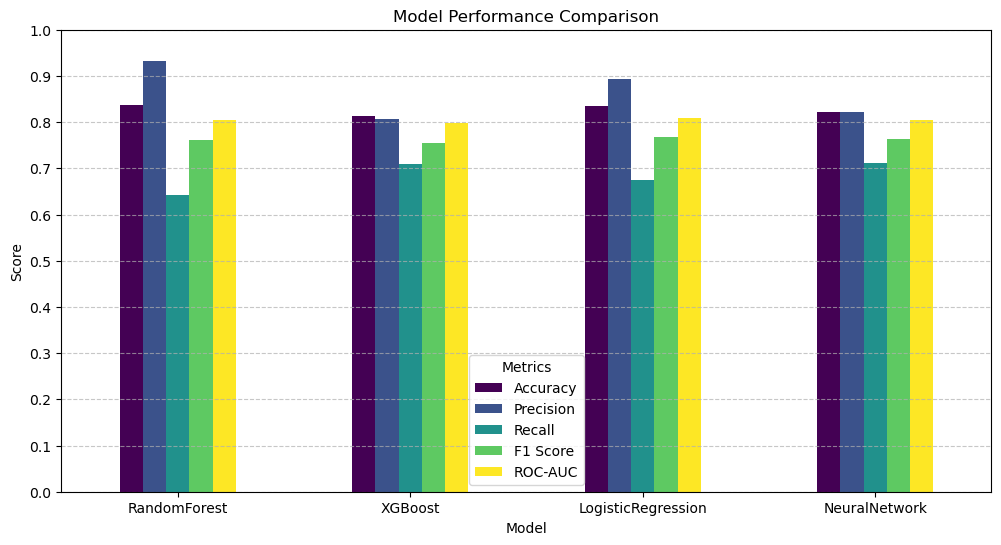

In [102]:
# Replace these variables with actual predictions from your models
models = ["RandomForest", "XGBoost", "LogisticRegression", "NeuralNetwork"]

accuracy = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_logit),
    accuracy_score(y_test, y_pred_nn)
]

precision = [
    precision_score(y_test, y_pred, average='binary'),
    precision_score(y_test, y_pred_xgb, average='binary'),
    precision_score(y_test, y_pred_logit, average='binary'),
    precision_score(y_test, y_pred_nn, average='binary')
]

recall = [
    recall_score(y_test, y_pred, average='binary'),
    recall_score(y_test, y_pred_xgb, average='binary'),
    recall_score(y_test, y_pred_logit, average='binary'),
    recall_score(y_test, y_pred_nn, average='binary')
]

f1_score_values = [
    f1_score(y_test, y_pred, average='binary'),
    f1_score(y_test, y_pred_xgb, average='binary'),
    f1_score(y_test, y_pred_logit, average='binary'),
    f1_score(y_test, y_pred_nn, average='binary')
]

roc_auc_scores = [
    roc_auc_score(y_test, y_pred),
    roc_auc_score(y_test, y_pred_xgb),
    roc_auc_score(y_test, y_pred_logit),
    roc_auc_score(y_test, y_pred_nn)
]

# Convert metrics to DataFrame
df_metrics = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score_values,
    "ROC-AUC": roc_auc_scores
})

# 📊 Plot Performance Metrics
fig, ax = plt.subplots(figsize=(12, 6))
df_metrics.set_index("Model").plot(kind="bar", ax=ax, rot=0, colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend

# Adjust Y-axis limits slightly above the highest score
plt.ylim(0, 1)

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set y-axis ticks with a step of 0.1
plt.yticks([i/10 for i in range(0, 11)])  # Generates ticks at 0.0, 0.1, ..., 1.0

plt.legend(title="Metrics")

# Show the plot
plt.show()


In [105]:
# Sort models by each metric in descending order
metrics_sorted = {
    "Accuracy": df_metrics.sort_values(by="Accuracy", ascending=False),
    "Precision": df_metrics.sort_values(by="Precision", ascending=False),
    "Recall": df_metrics.sort_values(by="Recall", ascending=False),
    "F1 Score": df_metrics.sort_values(by="F1 Score", ascending=False),
    "ROC-AUC": df_metrics.sort_values(by="ROC-AUC", ascending=False),
}

# Display each sorted table
for metric, df in metrics_sorted.items():
    print(f"\n🔹 {metric} (Sorted Best to Worst):")
    display(df[["Model", metric]])



🔹 Accuracy (Sorted Best to Worst):


,Model,Accuracy
0,RandomForest,0.836806
2,LogisticRegression,0.835568
3,NeuralNetwork,0.821070
1,XGBoost,0.813784



🔹 Precision (Sorted Best to Worst):


,Model,Precision
0,RandomForest,0.932567
2,LogisticRegression,0.892678
3,NeuralNetwork,0.821354
1,XGBoost,0.806260



🔹 Recall (Sorted Best to Worst):


,Model,Recall
3,NeuralNetwork,0.712432
1,XGBoost,0.710090
2,LogisticRegression,0.674414
0,RandomForest,0.642883



🔹 F1 Score (Sorted Best to Worst):


,Model,F1 Score
2,LogisticRegression,0.768347
3,NeuralNetwork,0.763026
0,RandomForest,0.761092
1,XGBoost,0.755126



🔹 ROC-AUC (Sorted Best to Worst):


,Model,ROC-AUC
2,LogisticRegression,0.809688
0,RandomForest,0.805664
3,NeuralNetwork,0.803623
1,XGBoost,0.797132
